# Measuring Compressibility of SOTU Addresses with Text Entropy

In this notebook, we'll look at the various SOTU addresses and see if we can construct a rudimentary measure of "how much the President is saying" by calculating the entropy of each document.

In [1]:
import pandas as pd
import os
from collections import Counter
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from scipy import misc

As in previous notebooks, we're going to prepare the data.

In [2]:
path = 'state-of-the-union-corpus-1989-2017'
dirs = os.listdir(path)

In [67]:
sotu_data = []
sotu_dict = {}

In [68]:
for i in range(len(dirs)):
    filename = os.path.join(path, dirs[i])
    text_file = open(filename, 'r')
    
    lines = text_file.read()
    lines = lines.replace('\n', ' ')
    
    clean_lines = ' '.join(filter(str.isalpha, lines.lower().split()))
    
    sotu_data.append(clean_lines)
    sotu_dict[filename] = clean_lines # store in dict so we can access lines by filename.

In [5]:
example = sotu_data[0]

In [6]:
split = example.split()

In [8]:
split2 = sotu_data[1].split()

In [9]:
c1 = Counter(split)
c2 = Counter(split2)

In [13]:
words = c1

In [14]:
for i in range(1, len(sotu_data)):
    splitWords = sotu_data[i].split()
    c = Counter(splitWords)
    words += c

In [15]:
words

Counter({'gentlemen': 53,
         'of': 96247,
         'the': 149148,
         'senate': 421,
         'and': 59887,
         'house': 459,
         'i': 9097,
         'was': 5598,
         'for': 18777,
         'some': 2082,
         'time': 2382,
         'apprehensive': 3,
         'that': 21183,
         'it': 13978,
         'would': 3688,
         'be': 18385,
         'on': 9293,
         'account': 241,
         'contagious': 18,
         'sickness': 12,
         'which': 11823,
         'afflicted': 20,
         'city': 235,
         'to': 60202,
         'convene': 16,
         'national': 2084,
         'legislature': 113,
         'at': 6899,
         'other': 3429,
         'this': 11717,
         'measure': 406,
         'desirable': 191,
         'because': 1020,
         'occasion': 215,
         'much': 1289,
         'public': 2933,
         'inconvenience': 46,
         'a': 27743,
         'considerable': 245,
         'expense': 234,
         'add': 178,
      

In [17]:
# sort dict highest to lowest first
import operator
sorted_words = sorted(words.items(), key=operator.itemgetter(1), reverse=True)

In [18]:
sorted_words

[('the', 149148),
 ('of', 96247),
 ('to', 60202),
 ('and', 59887),
 ('in', 38294),
 ('a', 27743),
 ('that', 21183),
 ('for', 18777),
 ('be', 18385),
 ('our', 17223),
 ('is', 16557),
 ('by', 14891),
 ('it', 13978),
 ('as', 12039),
 ('we', 11950),
 ('with', 11893),
 ('have', 11862),
 ('which', 11823),
 ('this', 11717),
 ('on', 9293),
 ('will', 9116),
 ('i', 9097),
 ('has', 8915),
 ('are', 8760),
 ('been', 8655),
 ('not', 8635),
 ('their', 7734),
 ('from', 7425),
 ('at', 6899),
 ('all', 6279),
 ('an', 5984),
 ('or', 5861),
 ('its', 5703),
 ('was', 5598),
 ('but', 5514),
 ('government', 5134),
 ('should', 5049),
 ('they', 4918),
 ('united', 4774),
 ('states', 4457),
 ('more', 4234),
 ('these', 4225),
 ('can', 4211),
 ('such', 3982),
 ('upon', 3866),
 ('would', 3688),
 ('congress', 3611),
 ('so', 3538),
 ('no', 3534),
 ('other', 3429),
 ('may', 3273),
 ('than', 3265),
 ('any', 3230),
 ('great', 3171),
 ('must', 3162),
 ('those', 3131),
 ('were', 3022),
 ('under', 3007),
 ('who', 2948),
 ('p

In [19]:
prob_dict = {}

In [20]:
space_size = sum(words.values()) # so we can get probabilities

In [22]:
for word in words.keys():
    prob_dict[word] = (words[word]) / space_size

In [23]:
sorted_probs = sorted(prob_dict.items(), key=operator.itemgetter(1), reverse=True)

In [24]:
sorted_probs

[('the', 0.09398204392734899),
 ('of', 0.06064774440069969),
 ('to', 0.03793485000478896),
 ('and', 0.03773636029096702),
 ('in', 0.024130047939991833),
 ('a', 0.01748158771607023),
 ('that', 0.013347960659968846),
 ('for', 0.011831877322014588),
 ('be', 0.011584867900369505),
 ('our', 0.01085266140049301),
 ('is', 0.01043299743412662),
 ('by', 0.009383207392135018),
 ('it', 0.0088079022850892),
 ('as', 0.0075860878244519165),
 ('we', 0.007530006603721272),
 ('with', 0.007494089417410635),
 ('have', 0.007474555509066254),
 ('which', 0.0074499805921168704),
 ('this', 0.0073831872281005986),
 ('on', 0.005855761620785087),
 ('will', 0.0057442293053994245),
 ('i', 0.005732256909962545),
 ('has', 0.005617573964198757),
 ('are', 0.0055199044224768495),
 ('been', 0.005453741184536202),
 ('not', 0.0054411386630236975),
 ('their', 0.004873395068885383),
 ('from', 0.004678686111517193),
 ('at', 0.004347239795738331),
 ('all', 0.003956561628850701),
 ('an', 0.003770674436541263),
 ('or', 0.003693

Now we compute entropy by running thru the prob_dict values, taking log_2 p(w) and summing over all words.

In [25]:
import math
entropy = 0

In [27]:
r = []
for address in sotu_data:
    split = address.split()
    r.extend(split)

In [28]:
for word in r:
    # get the probability from the dict
    prob = prob_dict[word]
    log_prob = math.log(prob, 2) # base 2 log
    # product = prob * log_prob
    entropy -= log_prob
entropy /= space_size # divide by |D|

In [29]:
entropy

9.120335524136818

The following is a function that'll take cleaned text (the way we made it) and return a number representing the entropy of the document.

In [55]:
def get_entropy(text):
    # takes in a cleaned string and gives entropy by using prob dictionary
    split = text.split()
    counts = Counter(split)
    space_size = sum(counts.values())
    
    # so we don't divide by zero.
    if space_size == 0:
        return float("inf")
    
    prob_dict = {}
    for word in counts.keys():
        prob_dict[word] = (counts[word]) / space_size
        
    # now we have prob dict, so we compute entropy
    entropy = 0
    for word in split:
        prob = prob_dict[word]
        log_prob = math.log(prob, 2)
        entropy -= log_prob
    entropy /= space_size
    
    return entropy

Now let's stuff all this in a dictionary.

In [56]:
sotu_entropies = {}

In [57]:
for name in sotu_dict.keys():
    address = sotu_dict[name]
    entropy = get_entropy(address)
    
    clean_name = name[36:-4]
    
    sotu_entropies[clean_name] = entropy

In [58]:
sotu_entropies

{'Adams_1797': 7.598896868410344,
 'Adams_1798': 7.691003178991555,
 'Adams_1799': 7.386124354411432,
 'Adams_1800': 7.347777117421941,
 'Adams_1825': 8.050858361602213,
 'Adams_1826': 7.930094357407056,
 'Adams_1827': 7.9299327712461904,
 'Adams_1828': 7.924965860446767,
 'Arthur_1881': 8.081879939852655,
 'Arthur_1882': 7.798544735097957,
 'Arthur_1883': 7.9363356451993115,
 'Arthur_1884': 8.352016511804619,
 'Buchanan_1857': 8.352650065395725,
 'Buchanan_1858': 8.426991040569346,
 'Buchanan_1859': 8.327494319230242,
 'Buchanan_1860': 8.30851236019275,
 'Buren_1837': 8.250756825266684,
 'Buren_1838': 8.224705065031989,
 'Buren_1839': 8.369429485860374,
 'Buren_1840': 8.272802603657736,
 'Bush_1989': 8.230151126582813,
 'Bush_1990': 7.91391211047201,
 'Bush_1991': 7.994058414363151,
 'Bush_1992': 8.132107830030513,
 'Bush_2001': 8.267919851091007,
 'Bush_2002': 8.265355539166025,
 'Bush_2003': 8.343151830115103,
 'Bush_2004': 8.34524763045016,
 'Bush_2005': 8.384339610748174,
 'Bush_2

In [59]:
sorted_entropies = sorted(sotu_entropies.items(), key=operator.itemgetter(1), reverse=True)

In [60]:
sorted_entropies

[('Washington_1790', inf),
 ('Carter_1981', 8.96368243129695),
 ('Roosevelt_1906', 8.657475440215547),
 ('Roosevelt_1905', 8.635317003478345),
 ('Roosevelt_1907', 8.631051695945441),
 ('Cleveland_1895', 8.628582528802376),
 ('Truman_1946', 8.622987107701237),
 ('Roosevelt_1901', 8.608873173777686),
 ('Obama_2014', 8.600990202964585),
 ('Obama_2012', 8.597670510414376),
 ('Roosevelt_1904', 8.596800697370368),
 ('Cleveland_1896', 8.596438762473188),
 ('Roosevelt_1908', 8.594882204519521),
 ('Eisenhower_1961', 8.594793559071382),
 ('McKinley_1898', 8.587511522411265),
 ('Obama_2013', 8.583244640956952),
 ('Taft_1912', 8.580742681063215),
 ('Cleveland_1894', 8.56540894774083),
 ('Cleveland_1885', 8.561257099437618),
 ('Eisenhower_1960', 8.545028834647916),
 ('Clinton_2000', 8.53454151767607),
 ('Taft_1911', 8.52751564804581),
 ('Trump_2018', 8.520156806147389),
 ('McKinley_1900', 8.517292708443746),
 ('Coolidge_1928', 8.504494795640893),
 ('Coolidge_1926', 8.496064826932503),
 ('Cleveland_

In [70]:
sotuDict = {k[36:-4] : v for k,v in sotu_dict.items()}

I'm surprised at how high trump is. Let's look at the top (Carter), Trump's, and the lowest entropy speeches as well as their lengths.

In [77]:
len(sotuDict['Carter_1981'])

183213

In [74]:
sotuDict['Carter_1981']

'to the congress of the united the state of the union is our economy is recovering from a a national energy plan is in place and our dependence on foreign oil is we have been at peace for four uninterrupted our nation has serious inflation and unemployment are unacceptably the world oil market is increasingly there are trouble spots throughout the and american hostages are being held in iran against international law and against every precept of human i firmly believe as a result of the progress made in so many domestic and international areas over the past four our nation is more compassionate and freer than it was four years i am proud of that and i believe the congress should be proud as for so much of what has been accomplished over the past four years has been due to the hard insights and cooperation of i applaud the congress for its efforts and its in this state of the union message i want to recount the achievements and progress of the last four years and to offer recommendation

In [155]:
len(sotuDict['Trump_2018'])

24076

In [75]:
sotuDict['Trump_2018']

'vice members of the first lady of the united and my fellow less than year has passed since i first stood at this in this majestic to speak on behalf of the american people and to address their their and their that our new administration had already taken swift a new tide of optimism was already sweeping across our each day we have gone forward with a clear vision and a righteous mission to make america great again for all over the last we have made incredible progress and achieved extraordinary we have faced challenges we and others we could never have we have shared in the heights of victory and the pains of we endured floods and fires and but through it we have seen the beauty of and the steel in each test has forged new american heroes to remind us who we and show us what we can we saw the volunteers of the racing to the rescue with their fishing boats to save people in the aftermath of a devastating we saw strangers shielding strangers from a hail of gunfire on the las vegas we he

In [156]:
len(sotuDict['Adams_1800'])

7195

In [76]:
sotuDict['Adams_1800']

'gentlemen of the senate and gentlemen of the house of immediately after the adjournment of congress at their last session in philadelphia i gave in compliance with the for the removal of the public and these directions have been and the public officers have since resided and conducted the ordinary business of the government in this i congratulate the people of the united states on the assembling of congress at the permanent seat of their and i congratulate on the prospect of a residence not to be although there is cause to apprehend that accommodations are not now so complete as might be yet there is great reason to believe that this inconvenience will cease with the present it would be unbecoming the representatives of this nation to assemble for the first time in this solemn temple without looking up to the supreme ruler of the universe and imploring his may this territory be the residence of virtue and in this city may that piety and that wisdom and that constancy and which adorned

It's worth noting that as we go from high to low in entropy here, the document size also goes from high to low. I wonder if the entropy is just measuring word size. Let's look at the last ten entropy lengths and compare them to the length of Carter, which was: 183213

In [78]:
bottom10 = sorted_entropies[-10:]

In [82]:
top10 = sorted_entropies[:10]

In [83]:
for val in bottom10:
    name = val[0]
    text = sotuDict[name]
    length = len(text)
    print("length of " + name + " was " + str(length))

length of Washington_1793 was 10176
length of Jefferson_1804 was 10975
length of Wilson_1916 was 11512
length of Adams_1797 was 10732
length of Madison_1809 was 9851
length of Nixon_1973 was 8203
length of Washington_1792 was 11006
length of Washington_1791 was 12337
length of Adams_1799 was 8048
length of Adams_1800 was 7195


In [84]:
for val in top10:
    name = val[0]
    text = sotuDict[name]
    length = len(text)
    print("length of " + name + " was " + str(length))

length of Washington_1790 was 0
length of Carter_1981 was 183213
length of Roosevelt_1906 was 119226
length of Roosevelt_1905 was 127906
length of Roosevelt_1907 was 139741
length of Cleveland_1895 was 78703
length of Truman_1946 was 146491
length of Roosevelt_1901 was 100230
length of Obama_2014 was 31417
length of Obama_2012 was 31882


In [85]:
len(sotuDict)

228

There are 228 addresses. Let's look somewhere closer to the middle and see what the lengths look like.

In [86]:
middle = sorted_entropies[100:140]

In [87]:
for val in middle:
    name = val[0]
    text = sotuDict[name]
    length = len(text)
    print("length of " + name + " was " + str(length))

length of Obama_2009 was 27705
length of Coolidge_1923 was 34742
length of Reagan_1987 was 17611
length of Johnson_1868 was 50764
length of Bush_2001 was 20798
length of Bush_2002 was 18058
length of Lincoln_1861 was 35488
length of Buren_1837 was 60393
length of Clinton_1996 was 29301
length of Grant_1873 was 50913
length of Eisenhower_1957 was 21664
length of Tyler_1844 was 48856
length of Tyler_1842 was 44119
length of Tyler_1841 was 43205
length of Bush_1989 was 21807
length of Jackson_1836 was 65198
length of Pierce_1855 was 61477
length of Buren_1838 was 60567
length of Lincoln_1863 was 31993
length of Fillmore_1850 was 43257
length of Hayes_1879 was 61480
length of Reagan_1986 was 16102
length of Roosevelt_1938 was 24018
length of Jackson_1835 was 57175
length of Ford_1975 was 19926
length of Grant_1874 was 46880
length of Ford_1977 was 22950
length of Grant_1870 was 44158
length of Truman_1948 was 25726
length of Jackson_1831 was 37963
length of Hoover_1932 was 22305
length of 

So what I was hoping is sort of true. It certainly appears that the longest addresses have the highest entropies and the shortest have the lowest (to an extent), but there are a number of cases where the lengths are "out of order".

In [88]:
textLengths = {}

In [89]:
for key in sotuDict.keys():
    text = sotuDict[key]
    length = len(text)
    
    textLengths[key] = length

In [90]:
sorted_lengths = sorted(textLengths.items(), key=operator.itemgetter(1), reverse=True)

In [91]:
def differences(a, b):
    if len(a) != len(b):
        raise ValueError("Lists of different length.")
    return sum(i != j for i, j in zip(a, b))

In [93]:
sorted_lengths

[('Carter_1981', 183213),
 ('Truman_1946', 146491),
 ('Roosevelt_1907', 139741),
 ('Taft_1912', 133925),
 ('Roosevelt_1905', 127906),
 ('Taft_1911', 124322),
 ('Roosevelt_1906', 119226),
 ('Polk_1848', 108705),
 ('McKinley_1898', 105748),
 ('Cleveland_1885', 104428),
 ('McKinley_1900', 100551),
 ('Roosevelt_1901', 100230),
 ('Roosevelt_1908', 98717),
 ('Polk_1846', 93220),
 ('Roosevelt_1904', 89124),
 ('Buchanan_1858', 84819),
 ('Cleveland_1894', 84690),
 ('Harrison_1891', 84674),
 ('Polk_1847', 84408),
 ('Polk_1845', 82797),
 ('Cleveland_1896', 80900),
 ('Cleveland_1886', 80597),
 ('McKinley_1899', 80341),
 ('Jackson_1830', 79653),
 ('Cleveland_1895', 78703),
 ('Roosevelt_1903', 75891),
 ('Taft_1909', 74593),
 ('Buchanan_1860', 71698),
 ('Jackson_1834', 71178),
 ('Buchanan_1857', 70379),
 ('Buren_1839', 69991),
 ('Harrison_1892', 69969),
 ('Fillmore_1851', 68960),
 ('Harrison_1889', 68153),
 ('Cleveland_1893', 65450),
 ('Jackson_1836', 65198),
 ('Buchanan_1859', 62666),
 ('McKinley_18

In [102]:
sorted_entropies

[('Washington_1790', inf),
 ('Carter_1981', 8.96368243129695),
 ('Roosevelt_1906', 8.657475440215547),
 ('Roosevelt_1905', 8.635317003478345),
 ('Roosevelt_1907', 8.631051695945441),
 ('Cleveland_1895', 8.628582528802376),
 ('Truman_1946', 8.622987107701237),
 ('Roosevelt_1901', 8.608873173777686),
 ('Obama_2014', 8.600990202964585),
 ('Obama_2012', 8.597670510414376),
 ('Roosevelt_1904', 8.596800697370368),
 ('Cleveland_1896', 8.596438762473188),
 ('Roosevelt_1908', 8.594882204519521),
 ('Eisenhower_1961', 8.594793559071382),
 ('McKinley_1898', 8.587511522411265),
 ('Obama_2013', 8.583244640956952),
 ('Taft_1912', 8.580742681063215),
 ('Cleveland_1894', 8.56540894774083),
 ('Cleveland_1885', 8.561257099437618),
 ('Eisenhower_1960', 8.545028834647916),
 ('Clinton_2000', 8.53454151767607),
 ('Taft_1911', 8.52751564804581),
 ('Trump_2018', 8.520156806147389),
 ('McKinley_1900', 8.517292708443746),
 ('Coolidge_1928', 8.504494795640893),
 ('Coolidge_1926', 8.496064826932503),
 ('Cleveland_

In [94]:
entropy_names = [val[0] for val in sorted_entropies]
length_names = [val[0] for val in sorted_lengths]

I did something silly and put Washington at the top of entropy names since I used infinity for the value since there's nothing there--here I'm just fiddling with the list so that entropy_names and length_names are actually in the same order by address.

In [99]:
# have to modify so 0 length at bottom.
entropy_names.append(entropy_names[0])
entropy_names = entropy_names[1:]

In [101]:
differences(entropy_names, length_names)

218

There are 218 differences between the two lengths--this means that the entropy isn't purely measuring document length as we were worried about.

Let's see how things have changed over time. We'll plot entropies and lengths of the newest and oldest addresses.

In [112]:
newestTen = []
oldestTen = []

In [106]:
sotu_chronological = sorted(sotuDict.items(), key=lambda kv: int(kv[0][-4:]))

In [113]:
for val in sotu_chronological[1:11]:
    oldestTen.append(val[0])

In [114]:
for val in sotu_chronological[-10:]:
    newestTen.append(val[0])

In [123]:
entropies_chronological = sorted(sorted_entropies, key=lambda val: int(val[0][-4:]))

In [124]:
lengths_chronological = sorted(sorted_lengths, key=lambda val: int(val[0][-4:]))

In [125]:
oldest_entropies = entropies_chronological[1:11]
newest_entropies = entropies_chronological[-10:]

We'll plot oldest/newest entropies together.

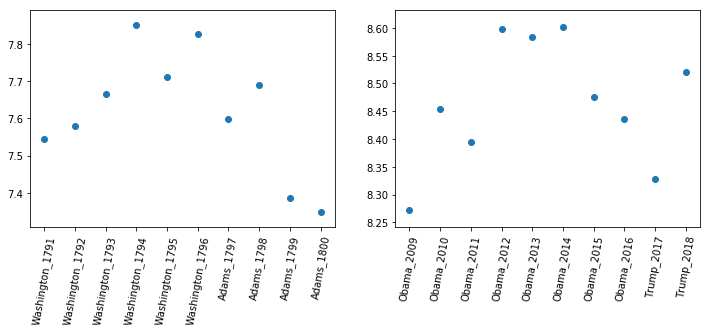

In [154]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.scatter(*zip(*oldest_entropies))
plt.xticks(rotation=80)

plt.subplot(1, 2, 2)
plt.scatter(*zip(*newest_entropies))
plt.xticks(rotation=80)

plt.show()

In [139]:
new_old = []
new_old.extend(oldest_entropies)
new_old.extend(newest_entropies)

And for more interpretability, let's see them in one graph.

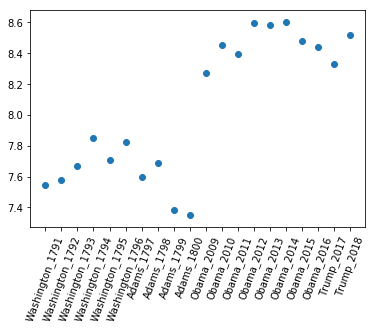

In [142]:
plt.scatter(*zip(*new_old))
plt.xticks(rotation=70)
plt.show()

In [149]:
oldest_lengths = lengths_chronological[1:11]
newest_lengths = lengths_chronological[-10:]

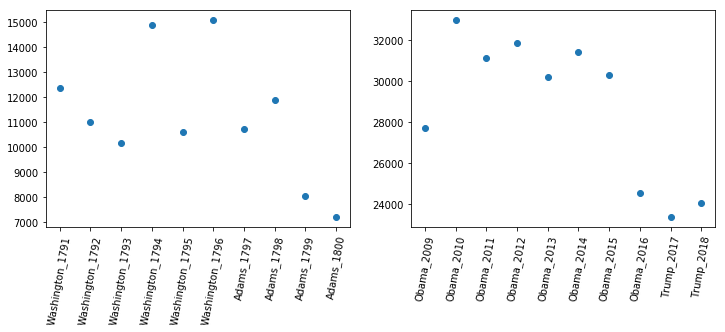

In [153]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.scatter(*zip(*oldest_lengths))
plt.xticks(rotation=80)

plt.subplot(1, 2, 2)
plt.scatter(*zip(*newest_lengths))
plt.xticks(rotation=80)

plt.show()

Even without plotting the above in a single graph, it's clear that the lengths are significantly different.